## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [25]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

# Download the latest version of the CelebA dataset
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# print("Path to dataset files:", path)
path = "/Users/yfahmy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/"

# Path to the directory where the CelebA images are stored
base_dir = os.path.join(path, "img_align_celeba")

# Image size to resize all images
image_dim = 200
num_channels = 3

images = []

# Optional: limit number of images if needed
MAX_IMAGES = 1000

# Loop through images in the dataset directory
for i, filename in enumerate(os.listdir(base_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(base_dir, filename)

        try:
            if num_channels == 3:
                img = Image.open(image_path).convert("RGB")
            else:
                img = Image.open(image_path).convert("L")
            img = img.resize((image_dim, image_dim))
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

        if i + 1 >= MAX_IMAGES:
            break

# Convert list to numpy array
images = np.array(images)

# Split into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Ensure the correct shape for TensorFlow (batch, height, width, channels)
x_train = x_train.reshape(len(x_train), image_dim, image_dim, num_channels)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, num_channels)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (800, 200, 200, 3), x_test shape: (200, 200, 200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.30635615486595..6.249687527685622].


<generator object <genexpr> at 0x33286d7e0>


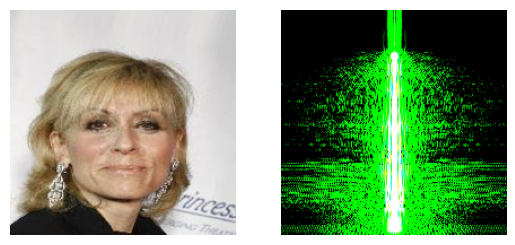

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003001794812252819..0.0030029368828625377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07259051891043053..0.9987883615495641].


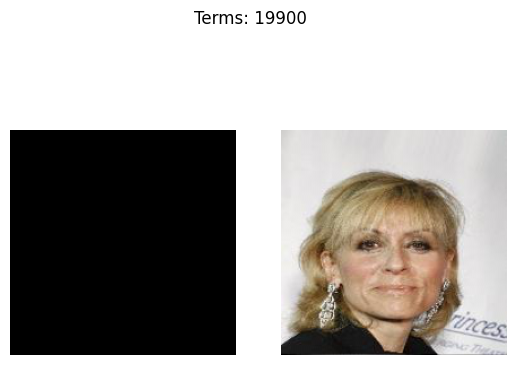

In [26]:
index = np.random.randint(len(x_train))
image = x_train[index]

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre) ** 2 + (coords[1] - centre) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]),
            centre + (centre - coords[1]))

def display_plots(individual_grating, reconstruction, idx):
    plt.subplot(121)
    plt.imshow(individual_grating)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(reconstruction)
    plt.axis("off")
    plt.suptitle(f"Terms: {idx}")
    plt.pause(0.01)

# # Read and process image
# image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

def foureir_transform(image, display=False):
    plt.set_cmap("gray")

    ft = calculate_2dft(image)

    if display:
        # Show grayscale image and its Fourier transform
        plt.subplot(121)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(np.log(abs(ft)))
        plt.axis("off")
        plt.pause(2)
        fig = plt.figure()

    return ft


def inverse_fourier_transform(ft, display=False):
    # Reconstruct image

    # Step 1
    # Set up empty arrays for final image and
    # individual gratings
    rec_image = np.zeros(image.shape)
    individual_grating = np.zeros(
        image.shape, dtype="complex"
    )
    idx = 0

    # All steps are displayed until display_all_until value
    display_all_until = 200
    # After this, skip which steps to display using the
    # display_step value
    display_step = 50
    # Work out index of next step to display
    next_display = display_all_until + display_step

    # Step 2
    for coords in coords_left_half:
        # Central column: only include if points in top half of
        # the central column
        if not (coords[1] == centre and coords[0] > centre):
            idx += 1
            symm_coords = find_symmetric_coordinates(
                coords, centre
            )
            # Step 3
            # Copy values from Fourier transform into
            # individual_grating for the pair of points in
            # current iteration
            individual_grating[coords] = ft[coords]
            individual_grating[symm_coords] = ft[symm_coords]

            # Step 4
            # Calculate inverse Fourier transform to give the
            # reconstructed grating. Add this reconstructed
            # grating to the reconstructed image
            rec_grating = calculate_2dift(individual_grating)
            rec_image += rec_grating

            # Clear individual_grating array, ready for
            # next iteration
            individual_grating[coords] = 0
            individual_grating[symm_coords] = 0

            # Don't display every step
            if idx < display_all_until or idx == next_display:
                if idx > display_all_until:
                    next_display += display_step
                    # Accelerate animation the further the
                    # iteration runs by increasing
                    # display_step
                    display_step += 10
    if display:
        display_plots(rec_grating, rec_image, idx)
        plt.show()
    return rec_image

# Array dimensions (array is square) and centre pixel
array_size = len(image)
centre = int((array_size - 1) / 2)

# Get all coordinate pairs in the left half of the array,
# including the column at the centre of the array (which
# includes the centre pixel)
coords_left_half = (
    (x, y) for x in range(array_size) for y in range(centre+1)
)
print(coords_left_half)

# Sort points based on distance from centre
coords_left_half = sorted(
    coords_left_half,
    key=lambda x: calculate_distance_from_centre(x, centre)
    )

ft = foureir_transform(image, display=True)
# plt.subplot(121)
# plt.imshow(np.log(abs(ft)))
# plt.axis("off")
# plt.subplot(122)
# plt.imshow(np.log(abs(ft)))
# plt.axis("off")
# plt.pause(2)
# fig = plt.figure()
rec_image = inverse_fourier_transform(ft, display=True)


## Add Gaussian Noise

In [27]:
noise_factor = 0.075
# Gaussian Noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32726530395797454..1.135660862693482].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.864491680892888..6.034673872569305].


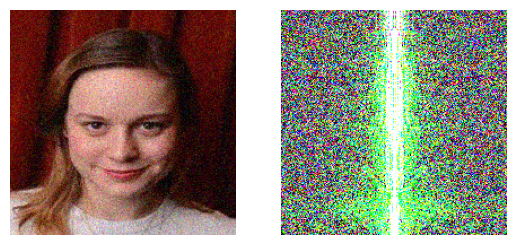

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.864491680892888..6.034673872569305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32948191687543515..1.1366767954951482].


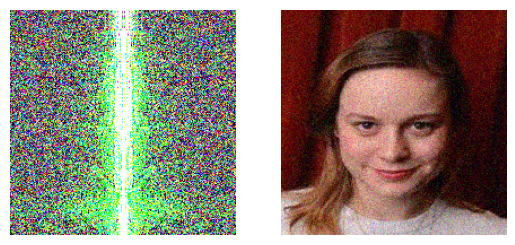

<Figure size 640x480 with 0 Axes>

In [28]:
index = np.random.randint(len(x_train_noisy))
image = x_train_noisy[index]
ft = foureir_transform(image)
plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.pause(2)
fig = plt.figure()
rec_image = inverse_fourier_transform(ft)
plt.subplot(121)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.subplot(122)
plt.imshow(rec_image)
plt.axis("off")
plt.pause(2)
fig = plt.figure()

## Add Salt and Pepper Noise

In [29]:
# def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
#     N, H, W, C = images.shape
#     rand_matrix = np.random.rand(N, H, W)
#     salt_mask = rand_matrix < salt_prob
#     pepper_mask = rand_matrix > (1 - pepper_prob)
#     images[salt_mask] = 255
#     images[pepper_mask] = 0
#     return images

# x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
# x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

## Calculate Fourier Transform of the Images

In [30]:
x_train_noisy_fourier = np.array([foureir_transform(image) for image in x_train_noisy])
x_train_fourier = np.array([foureir_transform(image) for image in x_train])
x_test_noisy_fourier = np.array([foureir_transform(image) for image in x_test_noisy])
x_test_fourier = np.array([foureir_transform(image) for image in x_test])


<Figure size 640x480 with 0 Axes>

In [31]:
def split_complex_channels(data):
    print(f"original shape: {data.shape}")
    """
    Converts (N, H, W, 3) complex64 array to (N, H, W, 6) real-valued array
    by separating real and imaginary parts of each channel.
    
    Parameters:
        data (np.ndarray): Complex-valued input of shape (N, H, W, 3)
    
    Returns:
        np.ndarray: Real-valued output of shape (N, H, W, 6)
    """
    res = np.concatenate([
        data.real,  # shape: (N, H, W, 3)
        data.imag   # shape: (N, H, W, 3)
    ], axis=-1)    # final shape: (N, H, W, 6)
    print(f"result shape: {res.shape}")
    return res


In [32]:
def combine_complex_channels(data):
    print(f"original shape: {data.shape}")
    """
    Converts (N, H, W, 6) real-valued array back to (N, H, W, 3) complex64 array
    by recombining real and imaginary parts for each of the 3 channels.
    
    Parameters:
        data (np.ndarray): Real-valued input of shape (N, H, W, 6)
    
    Returns:
        np.ndarray: Complex-valued output of shape (N, H, W, 3)
    """
    assert data.shape[-1] == 6, "Input must have 6 channels (3 real + 3 imag)"
    
    real = data[..., :3]  # First 3 channels: real
    imag = data[..., 3:]  # Last 3 channels: imag
    res = real + 1j * imag  # Shape: (N, H, W, 3), dtype=complex64
    print(f"result shape: {res.shape}")
    return res

In [33]:
x_train_noisy_split = split_complex_channels(x_train_noisy_fourier)
x_train_split = split_complex_channels(x_train_fourier)
x_test_noisy_split = split_complex_channels(x_test_noisy_fourier)
x_test_split = split_complex_channels(x_test_fourier)

original shape: (800, 200, 200, 3)
result shape: (800, 200, 200, 6)
original shape: (800, 200, 200, 3)
result shape: (800, 200, 200, 6)
original shape: (200, 200, 200, 3)
result shape: (200, 200, 200, 6)
original shape: (200, 200, 200, 3)
result shape: (200, 200, 200, 6)


In [34]:
# # clip the values in the range of 0-1
# x_train_noisy_fourier = np.clip(x_train_noisy_fourier, 0., 1.)
# x_test_noisy_fourier= np.clip(x_test_noisy_fourier, 0., 1.)

## Exploratory Data Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.193034731890275..6.277673956372239].


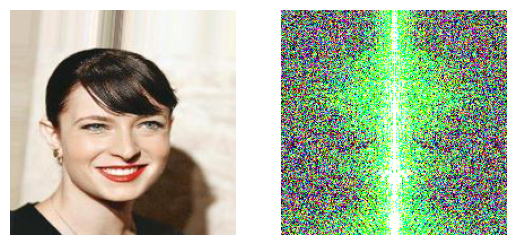

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.193034731890275..6.277673956372239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21163735494561614..1.2594746258051595].


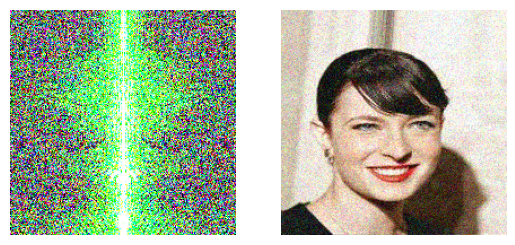

<Figure size 640x480 with 0 Axes>

In [35]:
index = np.random.randint(len(x_test_fourier))
image = x_test[index]
ft = x_test_noisy_fourier[index]
plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.pause(2)
fig = plt.figure()
rec_image = inverse_fourier_transform(ft)
plt.subplot(121)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.subplot(122)
plt.imshow(rec_image)
plt.axis("off")
plt.pause(2)
fig = plt.figure()

In [36]:
print(x_train_noisy_fourier.shape)

(800, 200, 200, 3)


## Model Creation

In [37]:
# Regular network
input_img = Input(shape=(image_dim, image_dim, num_channels * 2))  # to deal with complex numbers we need num of channels * 2

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

for _ in range(6): 
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(num_channels * 2, (3, 3), padding='same')(x) # to deal with complex numbers we need num of channels * 2

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 200, 200,  │      3,520 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 200, 200,  │          0 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 200, 200,  │     36,928 │ re_lu_11[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_13[0][0] 

 Total params: 230,086 (898.77 KB)

 Trainable params: 229,318 (895.77 KB)

 Non-trainable params: 768 (3.00 KB)

In [38]:
# train the model
model.fit(x_train_noisy_split, x_train_split, epochs=100 , batch_size=64, shuffle=True, validation_data=(x_test_noisy_split, x_test_split))
model.save("celeba_wavelet.keras")

Epoch 1/100


2025-03-24 09:44:54.364372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 2.1498 - val_loss: 5.1871
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 1.5679 - val_loss: 2.6994
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 1.2446 - val_loss: 2.6514
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.9134 - val_loss: 2.7989
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.6538 - val_loss: 2.1685
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.5127 - val_loss: 1.7487
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.4576 - val_loss: 1.3510
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.4322 - val_loss: 1.1815
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.4189 - val_loss: 1.1011
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.3941 - val_loss: 1.0464
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.3811 - val_loss: 0.9573
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.3708 - val_lo

## Visualize the Results

In [39]:
# predict the results from model (get compressed images)
predictions_split = model.predict(x_test_noisy_split)
predictions_fourier = combine_complex_channels(predictions_split)
predictions = np.array([inverse_fourier_transform(image) for image in predictions_fourier])

2025-03-24 10:26:28.679349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
original shape: (200, 200, 200, 6)
result shape: (200, 200, 200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20141684482755112..1.2034613972374548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1966016913558222..0.7986699836447603].


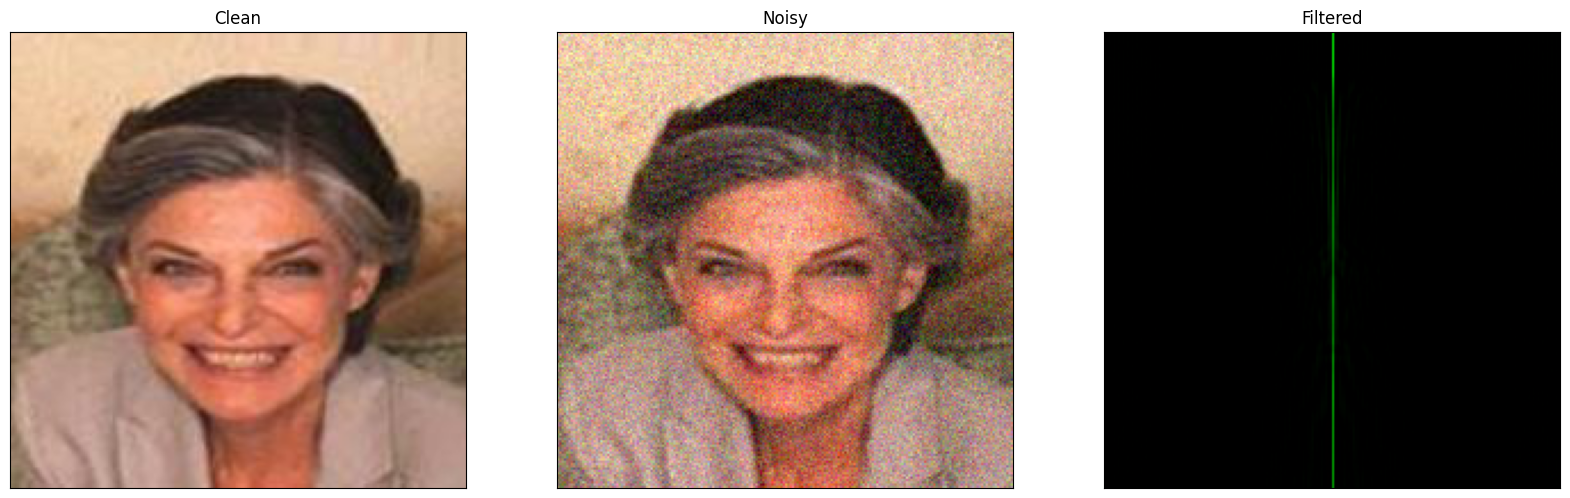

In [43]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,num_channels))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(inverse_fourier_transform(predictions[index].reshape(image_dim,image_dim,num_channels)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()